# Test FANET NN
Date: 07/03/2023

## Imports

In [1]:
import tensorflow as tf
import pandas as pd # for data manipulation 
import numpy as np
import glob, math, os
from scipy import special
from sklearn.metrics import accuracy_score

def euclidean_dist(row):
    # Function to calc euclidean distance on every df row 
    euc_dist = math.sqrt(row["U2G_Distance"]**2 - row["Height"]**2)
    return euc_dist

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    elif env == 'urban':
        a1 = 0.3
        a2 = 5e-4
        a3 = 15
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        if delta_h < 0:
            h1 = height_rx
            h2 = height_tx
        else:
            h1 = height_tx
            h2 = height_rx
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(h1/a3) - q_func(h2/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    elif env == "urban":
        n_min = 1.9
        n_max = 2.7
        K_dB_min = -5
        K_dB_max = 15
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 10.42 # Env parameters for logarithm std dev of shadowing 
        beta = 0.05 # Env parameters for logarithm std dev of shadowing 
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env=env)
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

2023-08-10 10:04:22.236275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 10:04:22.349877: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 10:04:22.354610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-10 10:04:22.354625: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

2023-08-10 10:04:22.986927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-10 10:04:22.986990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-10 10:04:22.986996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [11]:
[m,s] = sinr_lognormal_approx(0,60)
print(m,s)

1122.743643457063 465.2159856885714


## Load NN Model

### OLD Models

In [2]:
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2-2_21032023/model.010-2.0131.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2_hovering/model.001-0.9263.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2_hovering_sinr/model.001-0.9614.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v3_hovering/model.001-0.9333.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v3_hovering_sinr/model.001-0.9316.h5", compile=False)
model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2_hovering_novideo_sinr_ul/nn_v2_hovering_novideo_sinr_ul/model.006-1.5564.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2_hovering_novideo_sinr_dl/model.001-10.1139.h5", compile=False)
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss={'reliability': 'binary_crossentropy',
                    'incorrectly_received': 'categorical_crossentropy',
                    'delay_exceeded': 'binary_crossentropy',
                    'queue_overflow': 'binary_crossentropy'},
              metrics={'reliability': 'accuracy',
                    'incorrectly_received': 'accuracy',
                    'delay_exceeded': 'accuracy',
                    'queue_overflow': 'accuracy'})

2023-05-02 15:37:11.820016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-02 15:37:11.820138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-02 15:37:11.820218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-02 15:37:11.820292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-05-02 15:37:11.820365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### New Models

In [8]:
# # Uplink
model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v4_multimodulation_video_sinr_ul/model.004-0.1376.h5", compile=False)
# Downlink
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v4_multimodulation_novideo_nosinr_dl/model.005-0.2016.h5", compile=False)
# Video
# model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v4_multimodulation_video_nosinr_vid/model.005-0.2745.h5", compile=False)
model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

### Test using Taguchi Test Dataset

In [6]:
# Load test dataset
# test_data_df = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Stationary_Test_Dataset_NP10000_BPSK_6-5Mbps_downlink.h5", "Downlink")
test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_NP10000_64QAM_65Mbps_Hovering_NoVideo_uplink.csv")

# Calculate mean and std dev of SINR
test_data_df[['Mean_SINR',"Std_Dev_SINR"]]= test_data_df.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')

# Normalize inputs
max_h_dist = 510
max_height = 300
max_num_members = 39
max_bytes = 1500 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms
max_mean_sinr = 521 # The max mean SINR calculated at (50,60) is 520.2907250903191
max_std_dev_sinr = 252 # The max std dev SINR calculated at (50,60) is 251.44889082897834

h_dists = test_data_df["Horizontal_Distance"].values
heights = test_data_df["Height"].values
num_members = test_data_df["Num_Members"].values
# pkt_sizes = test_data_df["Packet_Size"].values
sending_ints = test_data_df["Sending_Interval"].values
mean_sinr = test_data_df["Mean_SINR"].values
std_dev_sinr = test_data_df["Std_Dev_SINR"].values

norm_h_dist = [h_dist / max_h_dist for h_dist in h_dists]
norm_height = [height / max_height for height in heights]
norm_num_members = [num_member / max_num_members for num_member in num_members]
# norm_pkt_size = [pkt_size / max_bytes for pkt_size in pkt_sizes]
norm_sending_int = [sending_int / max_sending_int for sending_int in sending_ints]
norm_mean_sinr = [m / max_mean_sinr for m in mean_sinr]
norm_std_dev_sinr = [s / max_std_dev_sinr for s in std_dev_sinr]

# For storing prediction results
predicted_reliability = []
predicted_incr_rcvd = [[],[],[],[],[],[],[],[]] # List of lists to store the prob of each incr rcvd probabilities
predicted_delay_excd = []
predicted_queue_overflow = []

# Run inference
# model_inputs = list(zip(norm_h_dist, norm_height, norm_num_members, norm_pkt_size, norm_sending_int))
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_num_members, norm_sending_int))
prediction = model.predict(model_inputs)
# print(prediction)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[1] for prob in prediction[0]]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[1] for prob in prediction[2]]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction[3]]
test_data_df['Predicted_0_Incr_Rcvd'] = [prob[0] for prob in prediction[1]]
test_data_df['Predicted_1_Incr_Rcvd'] = [prob[1] for prob in prediction[1]]
test_data_df['Predicted_2_Incr_Rcvd'] = [prob[2] for prob in prediction[1]]
test_data_df['Predicted_3_Incr_Rcvd'] = [prob[3] for prob in prediction[1]]
test_data_df['Predicted_4_Incr_Rcvd'] = [prob[4] for prob in prediction[1]]
test_data_df['Predicted_5_Incr_Rcvd'] = [prob[5] for prob in prediction[1]]
test_data_df['Predicted_6_Incr_Rcvd'] = [prob[6] for prob in prediction[1]]
test_data_df['Predicted_7_Incr_Rcvd'] = [prob[7] for prob in prediction[1]]

test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_NP10000_64QAM_65Mbps_Hovering_NoVideo_uplink_RESULTS_nn.csv")

15/15 [==============================] - 0s 4ms/step


### Test using Taguchi Test Dataset (Single Multiclass Reliability and Failure Modes Output)

In [9]:
# Set minimum probability for failure mode to be considered
MIN_FAILURE_PROB = 0.01

# Load test dataset
test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Test/Test_Dataset_1_Uplink_Reliability.csv")
# test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_Reliability.csv")
# Comment the below if using old files
test_data_df["Reliability"] = test_data_df["Num_Reliable"] / test_data_df["Num_Sent"]
test_data_df["Incorrectly_Rcvd_Prob"] = test_data_df["Num_Incr_Rcvd"] / test_data_df["Num_Sent"]
test_data_df["Queue_Overflow_Prob"] = test_data_df["Num_Q_Overflow"] / test_data_df["Num_Sent"]
test_data_df["Delay_Excd_Prob"] = test_data_df["Num_Delay_Excd"] / test_data_df["Num_Sent"]

# Calculate mean and std dev of SINR
test_data_df[['Mean_SINR',"Std_Dev_SINR"]] = test_data_df.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height'],"suburban"),axis=1,result_type='expand')
test_data_df["Mean_SINR"] = test_data_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
test_data_df["Std_Dev_SINR"] = test_data_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))

mean_sinr = test_data_df["Mean_SINR"].values
std_dev_sinr = test_data_df["Std_Dev_SINR"].values

# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)

norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = test_data_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = test_data_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# For storing prediction results
predicted_reliability = []
predicted_incr_rcvd = [] 
predicted_delay_excd = []
predicted_queue_overflow = []

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = model.predict(model_inputs)
# print(prediction)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[0] for prob in prediction]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction]
test_data_df['Predicted_Incr_Rcvd_Prob'] = [prob[2] for prob in prediction]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[3] for prob in prediction]

test_data_df["Reliability_Class"] = pd.cut(test_data_df["Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Predicted_Reliability_Class"] = pd.cut(test_data_df["Predicted_Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Failure_Mode"] = test_data_df[["Queue_Overflow_Prob", "Incorrectly_Rcvd_Prob", "Delay_Excd_Prob"]].idxmax(axis=1)
test_data_df["Predicted_Failure_Mode"] = test_data_df[["Predicted_Queue_Overflow_Prob", "Predicted_Incr_Rcvd_Prob", "Predicted_Delay_Excd_Prob"]].idxmax(axis=1)
# Replace label for Failure Mode with "None" if none of the failure modes have a probability > 5%
test_data_df.loc[(test_data_df["Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Incorrectly_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Failure_Mode"]] = "None"
test_data_df.loc[(test_data_df["Predicted_Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Incr_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Predicted_Failure_Mode"]] = "None"

# Compute the model accuracy and mean abs err
failure_mode = test_data_df["Failure_Mode"].replace({"Queue_Overflow_Prob":1, "Incorrectly_Rcvd_Prob":2, "Delay_Excd_Prob":3, "None":4})
failure_mode_predicted = test_data_df["Predicted_Failure_Mode"].replace({"Predicted_Queue_Overflow_Prob":1, "Predicted_Incr_Rcvd_Prob":2, "Predicted_Delay_Excd_Prob":3, "None":4})
reliability_accuracy = accuracy_score(test_data_df["Reliability_Class"], test_data_df["Predicted_Reliability_Class"])
failure_mode_accuracy = accuracy_score(failure_mode, failure_mode_predicted)
reliability_mae = np.mean(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_mae = np.mean(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_mae = np.mean(abs(test_data_df['Incorrectly_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_mae = np.mean(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))
reliability_maxae = np.max(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_maxae = np.max(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_maxae = np.max(abs(test_data_df['Incorrectly_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_maxae = np.max(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))

# Print results
print("Reliability - Accuracy: {}, MAE: {}, MaxAE: {}".format(reliability_accuracy, reliability_mae, reliability_maxae))
print("Failure Mode - Accuracy: {}".format(failure_mode_accuracy))
print("Queue Overflow - MeanAE: {}, MaxAE: {}".format(queue_overflow_mae, queue_overflow_maxae))
print("Incorrectly Received - MeanAE: {}, MaxAE: {}".format(incr_rcvd_mae, incr_rcvd_maxae))
print("Delay Exceeded - MeanAE: {}, MaxAE: {}".format(delay_excd_mae, delay_excd_maxae))

# Save results to file
test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Test_Dataset_1_Uplink_Reliability_NN_Results.csv")
# test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/NN_Downlink_Reliability_Results.csv")

30/30 [==============================] - 0s 2ms/step
Reliability - Accuracy: 0.9927083333333333, MAE: 0.0038538794746317663, MaxAE: 0.43060189493179324
Failure Mode - Accuracy: 0.9895833333333334
Queue Overflow - MeanAE: 0.005388583871195809, MaxAE: 0.1418640999889374
Incorrectly Received - MeanAE: 0.002226519570099602, MaxAE: 0.00872767425775528
Delay Exceeded - MeanAE: 0.005999698031298998, MaxAE: 0.41718262441635134


In [26]:
np.mean([0.00566187559881395, 0.005497301386443336, 0.003621054483198103])

0.004926743822818463

### Test using Taguchi Test Dataset (No SINR) (Single Multiclass Reliability and Failure Modes Output)

In [5]:
# Set minimum probability for failure mode to be considered
MIN_FAILURE_PROB = 0.01

# Load test dataset
test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Test/Multi_Modulation_Test_Cases_1_Uplink.csv")

# Get height and h_dist inputs
h_dist = test_data_df["Horizontal_Distance"].values
height = test_data_df["Height"].values

# Normalize inputs
max_height = 300
min_height = 60
max_h_dist = 1200
min_h_dist = 0

norm_h_dist = [2*(h_d-min_h_dist) / (max_h_dist-min_h_dist) - 1 for h_d in h_dist]
norm_height = [2*(h-min_height) / (max_height-min_height) - 1 for h in height]
norm_uav_send_int = test_data_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = test_data_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# For storing prediction results
predicted_reliability = []
predicted_incr_rcvd = [] 
predicted_delay_excd = []
predicted_queue_overflow = []

# Run inference
model_inputs = list(zip(norm_h_dist, norm_height, norm_uav_send_int, norm_modulation))
prediction = model.predict(model_inputs)
# print(prediction)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[0] for prob in prediction]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction]
test_data_df['Predicted_Incr_Rcvd_Prob'] = [prob[2] for prob in prediction]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[3] for prob in prediction]

test_data_df["Reliability_Class"] = pd.cut(test_data_df["Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Predicted_Reliability_Class"] = pd.cut(test_data_df["Predicted_Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Failure_Mode"] = test_data_df[["Queue_Overflow_Prob", "Incorrectly_Rcvd_Prob", "Delay_Excd_Prob"]].idxmax(axis=1)
test_data_df["Predicted_Failure_Mode"] = test_data_df[["Predicted_Queue_Overflow_Prob", "Predicted_Incr_Rcvd_Prob", "Predicted_Delay_Excd_Prob"]].idxmax(axis=1)
# Replace label for Failure Mode with "None" if none of the failure modes have a probability > 5%
test_data_df.loc[(test_data_df["Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Incorrectly_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Failure_Mode"]] = "None"
test_data_df.loc[(test_data_df["Predicted_Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Incr_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Predicted_Failure_Mode"]] = "None"

# Compute the model accuracy and mean abs err
failure_mode = test_data_df["Failure_Mode"].replace({"Queue_Overflow_Prob":1, "Incorrectly_Rcvd_Prob":2, "Delay_Excd_Prob":3, "None":4})
failure_mode_predicted = test_data_df["Predicted_Failure_Mode"].replace({"Predicted_Queue_Overflow_Prob":1, "Predicted_Incr_Rcvd_Prob":2, "Predicted_Delay_Excd_Prob":3, "None":4})
reliability_accuracy = accuracy_score(test_data_df["Reliability_Class"], test_data_df["Predicted_Reliability_Class"])
failure_mode_accuracy = accuracy_score(failure_mode, failure_mode_predicted)
reliability_mae = np.mean(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_mae = np.mean(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_mae = np.mean(abs(test_data_df['Incorrectly_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_mae = np.mean(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))
reliability_maxae = np.max(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_maxae = np.max(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_maxae = np.max(abs(test_data_df['Incorrectly_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_maxae = np.max(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))

# Print results
print("Reliability - Accuracy: {}, MAE: {}, MaxAE: {}".format(reliability_accuracy, reliability_mae, reliability_maxae))
print("Failure Mode - Accuracy: {}".format(failure_mode_accuracy))
print("Queue Overflow - MeanAE: {}, MaxAE: {}".format(queue_overflow_mae, queue_overflow_maxae))
print("Incorrectly Received - MeanAE: {}, MaxAE: {}".format(incr_rcvd_mae, incr_rcvd_maxae))
print("Delay Exceeded - MeanAE: {}, MaxAE: {}".format(delay_excd_mae, delay_excd_maxae))

# Save results to file
test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Test/Multi_Modulation_Test_Cases_1_Uplink_NN_NoSINR_RESULTS.csv")

# Get the results at the "drop" only
test_data_drop_df = test_data_df.loc[(test_data_df["Reliability"] < 0.99) & (test_data_df["Reliability"] > 0.01)]
    # Compute the model accuracy and mean abs err
failure_mode = test_data_drop_df["Failure_Mode"].replace({"Queue_Overflow_Prob":1, "Incorrectly_Rcvd_Prob":2, "Delay_Excd_Prob":3, "None":4})
failure_mode_predicted = test_data_drop_df["Predicted_Failure_Mode"].replace({"Predicted_Queue_Overflow_Prob":1, "Predicted_Incr_Rcvd_Prob":2, "Predicted_Delay_Excd_Prob":3, "None":4})
reliability_accuracy = accuracy_score(test_data_drop_df["Reliability_Class"], test_data_drop_df["Predicted_Reliability_Class"])
failure_mode_accuracy = accuracy_score(failure_mode, failure_mode_predicted)
reliability_mae = np.mean(abs(test_data_drop_df['Reliability'].values - test_data_drop_df['Predicted_Reliability'].values))
queue_overflow_mae = np.mean(abs(test_data_drop_df['Queue_Overflow_Prob'].values - test_data_drop_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_mae = np.mean(abs(test_data_drop_df['Incorrectly_Rcvd_Prob'].values - test_data_drop_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_mae = np.mean(abs(test_data_drop_df['Delay_Excd_Prob'].values - test_data_drop_df['Predicted_Delay_Excd_Prob'].values))
reliability_maxae = np.max(abs(test_data_drop_df['Reliability'].values - test_data_drop_df['Predicted_Reliability'].values))
queue_overflow_maxae = np.max(abs(test_data_drop_df['Queue_Overflow_Prob'].values - test_data_drop_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_maxae = np.max(abs(test_data_drop_df['Incorrectly_Rcvd_Prob'].values - test_data_drop_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_maxae = np.max(abs(test_data_drop_df['Delay_Excd_Prob'].values - test_data_drop_df['Predicted_Delay_Excd_Prob'].values))
print("RESULTS AT DROP REGION =====================================")
print("Reliability - Accuracy: {}, MAE: {}, MaxAE: {}".format(reliability_accuracy, reliability_mae, reliability_maxae))
print("Failure Mode - Accuracy: {}".format(failure_mode_accuracy))
print("Queue Overflow - MeanAE: {}, MaxAE: {}".format(queue_overflow_mae, queue_overflow_maxae))
print("Incorrectly Received - MeanAE: {}, MaxAE: {}".format(incr_rcvd_mae, incr_rcvd_maxae))
print("Delay Exceeded - MeanAE: {}, MaxAE: {}".format(delay_excd_mae, delay_excd_maxae))


30/30 [==============================] - 0s 2ms/step
Reliability - Accuracy: 0.9927083333333333, MAE: 0.002744380153625911, MaxAE: 0.49762199378013616
Failure Mode - Accuracy: 0.9916666666666667
Queue Overflow - MeanAE: 0.004665819713344343, MaxAE: 0.16435093121528627
Incorrectly Received - MeanAE: 0.0007674163412448138, MaxAE: 0.003962640689872205
Delay Exceeded - MeanAE: 0.006224850996109199, MaxAE: 0.4828524098396301


### Test for specific experiment no.

In [4]:
from itertools import repeat

# h_dists = [50, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500] # In m
# h_dists = [150, 175, 200, 225, 250, 300, 350, 400, 450, 500] # In m
# h_dists = [50, 75, 100, 112.5, 125, 137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225, 237.5, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500] # In m
# h_dists = [75, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 275, 325, 375, 425, 475] # In m
# h_dists = [50, 100, 112.5, 125, 137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225, 237.5, 250, 300, 350, 400, 450, 500] # In m
h_dists = np.linspace(20,500,num=49,endpoint=True)
# h_dist = 30
height = 70 # In m
# heights = np.linspace(60,300,num=25,endpoint=True)
# u2g_dist = [math.sqrt(h_dist**2 + height**2) for h_dist in h_dists]
num_members = 7
pkt_size = 50 # In bytes
sending_int = 10 # In ms
snr_moments = [sinr_lognormal_approx(h_dist, height) for h_dist in h_dists]
# snr_moments = [sinr_lognormal_approx(h_dist, height) for height in heights]
mean_snr = [x[0] for x in snr_moments]
std_dev_snr = [x[1] for x in snr_moments]

# max_h_dist = 550
max_h_dist = 500
max_height = 300
max_num_members = 39
# max_num_members = 7
max_bytes = 1500 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms
# max_mean_sinr = 6193 # The max mean SINR calculated at (0,24) is 668.1670595316114
# max_std_dev_sinr = 2780 # The max std dev SINR calculated at (0,24) is 578.6543714478831
max_mean_sinr = 521 # The max mean SINR calculated at (0,24) is 520.2907250903191
max_std_dev_sinr = 252 # The max std dev SINR calculated at (0,24) is 251.44889082897834

# norm_h_dist = [h_dist / max_h_dist for h_dist in h_dists]
# norm_height = height / max_height
norm_num_members = num_members / max_num_members
norm_pkt_size = pkt_size / max_bytes
norm_sending_int = sending_int / max_sending_int
norm_mean_snr = [m / max_mean_sinr for m in mean_snr]
norm_std_dev_snr = [s / max_std_dev_sinr for s in std_dev_snr]

model_inputs = list(zip(norm_mean_snr, norm_std_dev_snr, repeat(norm_num_members), repeat(norm_sending_int)))
# model_inputs = list(zip(norm_mean_snr, norm_std_dev_snr, repeat(norm_num_members), repeat(norm_pkt_size), repeat(norm_sending_int)))
# model_inputs = list(zip(norm_h_dist, repeat(norm_height), repeat(norm_num_members), repeat(norm_pkt_size), repeat(norm_sending_int)))
# model_input = [norm_h_dist,norm_height,norm_num_members,norm_pkt_size,norm_sending_int]

prediction = model.predict(model_inputs)
# print(prediction)
print([p[1] for p in prediction[0]])

2/2 [==============================] - 0s 6ms/step
[0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.9999953, 0.9997854, 0.99973774, 0.9927658, 0.35241845, 0.10420601, 0.0017122723, 2.3735553e-05, 1.0709967e-06, 7.4764095e-08, 3.426935e-08, 1.8313905e-08, 1.5328803e-08, 3.7511794e-09, 1.007431e-09, 5.522583e-10, 3.1600253e-10, 1.91892e-10, 1.2267251e-10, 8.191211e-11, 5.1374297e-11, 3.3649573e-11, 2.2897871e-11, 1.6116471e-11, 1.1688064e-11, 3.3484007e-11, 1.2179403e-10, 3.05861e-10, 6.8554873e-10, 1.392557e-09, 2.5971767e-09, 4.49703e-09, 7.082125e-09, 1.0354178e-08, 1.4484203e-08, 1.9491704e-08, 2.0031996e-08, 2.0026189e-08, 2.0023096e-08, 2.0022332e-08, 2.0023592e-08, 2.002661e-08, 2.0031042e-08, 1.9356996e-08]


### Test for single case

In [6]:
from itertools import repeat

h_dist = 149.966715057041 # In m
height = 24 # In m
num_members = 15
pkt_size = 360 # In bytes
sending_int = 520 # In ms

max_h_dist = 550
max_height = 120
max_num_members = 39
max_bytes = 1145 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms

norm_h_dist = h_dist / max_h_dist
norm_height = height / max_height
norm_num_members = num_members / max_num_members
norm_pkt_size = pkt_size / max_bytes
norm_sending_int = sending_int / max_sending_int

model_inputs = [norm_h_dist, norm_height, norm_num_members, norm_pkt_size, norm_sending_int]
# model_input = [norm_h_dist,norm_height,norm_num_members,norm_pkt_size,norm_sending_int]

prediction = model.predict([model_inputs])
print(prediction)

1/1 [==============================] - 0s 39ms/step
[array([[4.8760677e-04, 9.9951243e-01]], dtype=float32), array([[0.49350592, 0.2441833 , 0.13018824, 0.07528864, 0.03120731,
        0.01573893, 0.0084472 , 0.0014404 ]], dtype=float32), array([[9.9970812e-01, 2.9182597e-04]], dtype=float32), array([[1.0000000e+00, 2.2164258e-20]], dtype=float32)]


## Load BNN Model

In [48]:
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Input

# kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (len(X_train_all))
# bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (len(X_train_all))

inputs = Input(shape=(5,))
base = tfp.layers.DenseFlipout(50, activation='relu')(inputs)
base = tfp.layers.DenseFlipout(25, activation='relu')(base)
base = tfp.layers.DenseFlipout(10, activation='relu')(base)
reliability_hl = tfp.layers.DenseFlipout(10, activation='relu')(base)
incr_rcvd_out_hl = tfp.layers.DenseFlipout(10, activation='relu')(base)
delay_excd_hl = tfp.layers.DenseFlipout(10, activation='relu')(base)
queue_overflow_hl = tfp.layers.DenseFlipout(10, activation='relu')(base)
reliability_out = tfp.layers.DenseFlipout(2, activation='softmax', name='reliability')(reliability_hl)
incr_rcvd_out = tfp.layers.DenseFlipout(8, activation='softmax', name='incorrectly_received')(incr_rcvd_out_hl)
delay_excd_out = tfp.layers.DenseFlipout(2, activation='softmax', name='delay_exceeded')(delay_excd_hl)
queue_overflow_out = tfp.layers.DenseFlipout(2, activation='softmax', name='queue_overflow')(queue_overflow_hl)
model = Model(inputs=inputs, outputs = [reliability_out, incr_rcvd_out, delay_excd_out, queue_overflow_out])

model.compile(optimizer='adam', 
              loss={'reliability': 'binary_crossentropy',
                    'incorrectly_received': 'categorical_crossentropy',
                    'delay_exceeded': 'binary_crossentropy',
                    'queue_overflow': 'binary_crossentropy'},
              metrics={'reliability': 'accuracy',
                    'incorrectly_received': 'accuracy',
                    'delay_exceeded': 'accuracy',
                    'queue_overflow': 'accuracy'},)

model.load_weights("/home/research-student/omnet-fanet/nn_checkpoints/bnn_v2_hovering_novideo_sinr/model.030-0.5846.h5")

### Test for specific experiment no.

In [49]:
from itertools import repeat

# h_dists = [50, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500] # In m
# h_dists = [150, 175, 200, 225, 250, 300, 350, 400, 450, 500] # In m
# h_dists = [50, 75, 100, 112.5, 125, 137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225, 237.5, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500] # In m
# h_dists = [75, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 275, 325, 375, 425, 475] # In m
# h_dists = [50, 100, 112.5, 125, 137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225, 237.5, 250, 300, 350, 400, 450, 500] # In m
h_dist = np.linspace(20,500,num=49,endpoint=True)
height = 60 # In m
u2g_dist = [math.sqrt(h_dist**2 + height**2) for h_dist in h_dists]
num_members = 7
pkt_size = 50 # In bytes
sending_int = 10 # In ms
snr_moments = [sinr_lognormal_approx(h_dist, height) for h_dist in h_dists]
mean_snr = [x[0] for x in snr_moments]
std_dev_snr = [x[1] for x in snr_moments]

# max_h_dist = 550
max_h_dist = 500
max_height = 300
max_num_members = 39
# max_num_members = 7
max_bytes = 1500 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms
# max_mean_sinr = 6193 # The max mean SINR calculated at (0,24) is 668.1670595316114
# max_std_dev_sinr = 2780 # The max std dev SINR calculated at (0,24) is 578.6543714478831
max_mean_sinr = 521 # The max mean SINR calculated at (50,60) is 520.2907250903191
max_std_dev_sinr = 252 # The max std dev SINR calculated at (50,60) is 251.44889082897834

norm_h_dist = [h_dist / max_h_dist for h_dist in h_dists]
norm_height = height / max_height
norm_num_members = num_members / max_num_members
norm_pkt_size = pkt_size / max_bytes
norm_sending_int = sending_int / max_sending_int
norm_mean_snr = [m / max_mean_sinr for m in mean_snr]
norm_std_dev_snr = [s / max_std_dev_sinr for s in std_dev_snr]

model_inputs = list(zip(norm_mean_snr, norm_std_dev_snr, repeat(norm_num_members), repeat(norm_pkt_size), repeat(norm_sending_int)))
# model_inputs = list(zip(norm_h_dist, repeat(norm_height), repeat(norm_num_members), repeat(norm_pkt_size), repeat(norm_sending_int)))
# model_input = [norm_h_dist,norm_height,norm_num_members,norm_pkt_size,norm_sending_int]


prediction = []
for i in range(100):
    prediction.append([p[1] for p in model.predict(model_inputs)[0]])
prediction = np.array(prediction).mean(axis=0)
# print([p[1] for p in prediction[0]])
print(prediction.tolist())

1/1 [==============================] - 0s 36ms/step
[0.9999999403953552, 0.9999996423721313, 0.999481737613678, 0.015482890419661999, 6.9508882916125e-06, 1.7113026160586742e-06, 6.088038162488374e-07, 3.168134696807101e-07, 1.918535019740375e-07, 1.4957397809212125e-07, 8.649522698078727e-08, 6.263967122777103e-08, 4.356937211014156e-08, 2.0562852753869265e-08, 2.3365576140577105e-08, 3.338783116646482e-08, 3.976461826482591e-08, 4.147893051253959e-08, 2.061490889104789e-08]


## Version 2 NN

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd

model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2-20032023/final_model.h5", compile=False)
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss={'reliability': 'binary_crossentropy',
                    'incorrectly_received': 'categorical_crossentropy',
                    'delay_exceeded': 'binary_crossentropy',
                    'queue_overflow': 'binary_crossentropy'},
              metrics={'reliability': 'accuracy',
                    'incorrectly_received': 'accuracy',
                    'delay_exceeded': 'accuracy',
                    'queue_overflow': 'accuracy'},)

### Test using Taguchi Test Dataset

In [4]:
# Load test dataset
test_data_df = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Stationary_Test_Dataset_NP10000_BPSK_6-5Mbps_downlink.h5", "Downlink")

# Normalize inputs
max_h_dist = 550
max_height = 120
max_num_members = 39
max_bytes = 1145 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms

h_dists = test_data_df["Horizontal_Distance"].values
heights = test_data_df["Height"].values
num_members = test_data_df["Num_Members"].values
pkt_sizes = test_data_df["Packet_Size"].values
sending_ints = test_data_df["Sending_Interval"].values

norm_h_dist = [h_dist / max_h_dist for h_dist in h_dists]
norm_height = [height / max_height for height in heights]
norm_num_members = [num_member / max_num_members for num_member in num_members]
norm_pkt_size = [pkt_size / max_bytes for pkt_size in pkt_sizes]
norm_sending_int = [sending_int / max_sending_int for sending_int in sending_ints]

# For storing prediction results
predicted_reliability = []
predicted_incr_rcvd = [[],[],[],[],[],[],[],[]] # List of lists to store the prob of each incr rcvd probabilities
predicted_delay_excd = []
predicted_queue_overflow = []

# Run inference
model_inputs = list(zip(norm_h_dist, norm_height, norm_num_members, norm_pkt_size, norm_sending_int))
prediction = model.predict(model_inputs)
# print(prediction)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[1] for prob in prediction[0]]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[1] for prob in prediction[2]]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction[3]]
test_data_df['Predicted_0_Incr_Rcvd'] = [prob[0] for prob in prediction[1]]
test_data_df['Predicted_1_Incr_Rcvd'] = [prob[1] for prob in prediction[1]]
test_data_df['Predicted_2_Incr_Rcvd'] = [prob[2] for prob in prediction[1]]
test_data_df['Predicted_3_Incr_Rcvd'] = [prob[3] for prob in prediction[1]]
test_data_df['Predicted_4_Incr_Rcvd'] = [prob[4] for prob in prediction[1]]
test_data_df['Predicted_5_Incr_Rcvd'] = [prob[5] for prob in prediction[1]]
test_data_df['Predicted_6_Incr_Rcvd'] = [prob[6] for prob in prediction[1]]
test_data_df['Predicted_7_Incr_Rcvd'] = [prob[7] for prob in prediction[1]]

test_data_df.to_csv("Stationary_Test_Dataset_NP10000_BPSK_6-5Mbps_downlink_RESULTS_nnv2.csv")

11/11 [==============================] - 0s 5ms/step


## Version 2-2 NN

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v2-2_21032023/model.010-2.0131.h5", compile=False)
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss={'reliability': 'binary_crossentropy',
                    'incorrectly_received': 'categorical_crossentropy',
                    'delay_exceeded': 'binary_crossentropy',
                    'queue_overflow': 'binary_crossentropy'},
              metrics={'reliability': 'accuracy',
                    'incorrectly_received': 'accuracy',
                    'delay_exceeded': 'accuracy',
                    'queue_overflow': 'accuracy'},)

2023-03-21 14:51:19.033354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 14:51:19.163811: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 14:51:19.168666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 14:51:19.168682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### Test using Taguchi Test Dataset

In [2]:
# Load test dataset
test_data_df = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Stationary_Test_Dataset_NP10000_BPSK_6-5Mbps_downlink.h5", "Downlink")

# Normalize inputs
max_h_dist = 550
max_height = 120
max_num_members = 39
max_bytes = 1145 # Should be 1144, but put 1145 just in case
max_sending_int = 1000 # In ms

h_dists = test_data_df["Horizontal_Distance"].values
heights = test_data_df["Height"].values
num_members = test_data_df["Num_Members"].values
pkt_sizes = test_data_df["Packet_Size"].values
sending_ints = test_data_df["Sending_Interval"].values

norm_h_dist = [h_dist / max_h_dist for h_dist in h_dists]
norm_height = [height / max_height for height in heights]
norm_num_members = [num_member / max_num_members for num_member in num_members]
norm_pkt_size = [pkt_size / max_bytes for pkt_size in pkt_sizes]
norm_sending_int = [sending_int / max_sending_int for sending_int in sending_ints]

# For storing prediction results
predicted_reliability = []
predicted_incr_rcvd = [[],[],[],[],[],[],[],[]] # List of lists to store the prob of each incr rcvd probabilities
predicted_delay_excd = []
predicted_queue_overflow = []

# Run inference
model_inputs = list(zip(norm_h_dist, norm_height, norm_num_members, norm_pkt_size, norm_sending_int))
prediction = model.predict(model_inputs)
# print(prediction)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[1] for prob in prediction[0]]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[1] for prob in prediction[2]]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction[3]]
test_data_df['Predicted_0_Incr_Rcvd'] = [prob[0] for prob in prediction[1]]
test_data_df['Predicted_1_Incr_Rcvd'] = [prob[1] for prob in prediction[1]]
test_data_df['Predicted_2_Incr_Rcvd'] = [prob[2] for prob in prediction[1]]
test_data_df['Predicted_3_Incr_Rcvd'] = [prob[3] for prob in prediction[1]]
test_data_df['Predicted_4_Incr_Rcvd'] = [prob[4] for prob in prediction[1]]
test_data_df['Predicted_5_Incr_Rcvd'] = [prob[5] for prob in prediction[1]]
test_data_df['Predicted_6_Incr_Rcvd'] = [prob[6] for prob in prediction[1]]
test_data_df['Predicted_7_Incr_Rcvd'] = [prob[7] for prob in prediction[1]]

test_data_df.to_csv("Stationary_Test_Dataset_NP10000_BPSK_6-5Mbps_downlink_RESULTS_nn_V2-2.csv")

11/11 [==============================] - 0s 4ms/step


In [11]:
df = pd.read_hdf("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_64QAM_65Mbps_Hovering/Dataset_NP10000_64QAM_65Mbps_Hovering_8UAVs_processed_downlink.h5", key="8_UAVs")


In [ ]:
import keras
from keras.models import Model
import numpy as np

autoencoder = keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/ae_multimodulation_novideo_sinr_ul/final_model.h5", compile=False)
autoencoder.compile(optimizer='adam', loss='mse', metrics='mse')
# Get the encoder part of the autoencoder
encoder_layer = autoencoder.get_layer('latent')
encoder = Model(inputs=autoencoder.input, outputs=encoder_layer.output)

out = encoder.predict([[1,0.2,0.3,0.4],[0.5,0.6,0.7,0.8]])
out = np.concatenate((out, encoder.predict([[1,0.2,0.3,0.4],[0.5,0.6,0.7,0.8]])), axis=0)

print(out)
print(out.shape)

## Test Autoencoder

In [20]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Concatenate
import numpy as np

autoencoder = keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/ae_multimodulation_novideo_sinr_ul/final_model.h5", compile=False)
autoencoder.compile(optimizer='adam', loss='mse', metrics='mse')
# Get the encoder part of the autoencoder
encoder_input = autoencoder.get_layer('encoder')
encoder_layer = autoencoder.get_layer('latent')
# Freeze the encoder part
encoder_input.trainable = False
encoder_layer.trainable = False
# Create hierarchical model
haenn = keras.Sequential(
    [
        Input(shape=(4,)),
        encoder_input,
        encoder_layer,
        Dense(25, activation='relu', name='classifier_1'),
        BatchNormalization(name='batch_norm_1'), 
        Dense(10, activation='relu', name='classifier_2'),
        BatchNormalization(name='batch_norm_2'), 
        Dense(1, activation='linear', name='indicator')
    ]
)

haenn.compile(optimizer='adam', 
              loss={'indicator': 'mae'},
              metrics={'indicator': 'accuracy'})


# Test Throughput NN

In [2]:
# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
throughput_model.compile(optimizer='adam', 
              loss={'throughput': 'mse'},
              metrics={'throughput': 'accuracy'})

# Set the link type IMPORTANT!!!
link_type = 'downlink'

# Load test dataset
test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Test/Test_Dataset_1_Downlink_MeanThroughput.csv")
# test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_MeanThroughput.csv")

# Calculate mean and std dev of SINR
test_data_df[['Mean_SINR',"Std_Dev_SINR"]] = test_data_df.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
test_data_df["Mean_SINR_dB"] = test_data_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
test_data_df["Std_Dev_SINR_dB"] = test_data_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))

mean_sinr = test_data_df["Mean_SINR_dB"].values
std_dev_sinr = test_data_df["Std_Dev_SINR_dB"].values

# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)

norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = test_data_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = test_data_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)
# print(prediction)

# Convert output to throughput in bps
if link_type == "uplink":
    # max_throughput = 10*math.log10(500000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 500000
    min_throughput = 0
elif link_type == "downlink":
    # max_throughput = 10*math.log10(20000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 20000
    min_throughput = 0
elif link_type == "video":
    # max_throughput = 10*math.log10(250000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 250000 
    min_throughput = 0
# (10*math.log10(x)-min_throughput)/(max_throughput-min_throughput)
# test_data_df['Predicted_Throughput'] = [10**((prob[0]*(max_throughput-min_throughput)+min_throughput)/10) for prob in prediction]
test_data_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]

throughput_mae = np.mean(abs(test_data_df['MeanThroughput'].values - test_data_df['Predicted_Throughput'].values))
throughput_max_ae = np.max(abs(test_data_df['MeanThroughput'].values - test_data_df['Predicted_Throughput'].values))

# Print results
print("Throughput - MAE: {}, MaxAE: {}".format(throughput_mae, throughput_max_ae))

# test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_NoVideo/Test/Multi_Modulation_Test_Cases_Uplink_NN_Throughput_RESULTS.csv")
# test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Video_Multi_Modulation_Test_Cases_1_Downlink_Throughput_NN_RESULTS.csv")
test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP100000_MultiModulation_Hovering_Video/Test/Test_Dataset_1_Downlink_Throughput_NN_Results.csv")

2023-08-02 11:59:26.055496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-02 11:59:26.055589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-02 11:59:26.055648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-02 11:59:26.055702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-08-02 11:59:26.055757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

30/30 [==============================] - 0s 4ms/step
Throughput - MAE: 102.56724347976599, MaxAE: 7214.190617217042


In [8]:
# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
# throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_multimodulation_video_sinr_ul/model.005-0.0007.h5", compile=False)
throughput_model.compile(optimizer='adam', 
              loss={'throughput': 'mse'},
              metrics={'throughput': 'accuracy'})

# Set the link type IMPORTANT!!!
link_type = 'downlink'

# Load test dataset
test_data_df = pd.DataFrame({"Horizontal_Distance": [i*20 for i in range(15)],
                             "Height": [60 for i in range(15)],
                             "Modulation": ["QAM16" for i in range(15)],
                             "UAV_Sending_Interval": [20 for i in range(15)]})
# test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_MeanThroughput.csv")

# Calculate mean and std dev of SINR
test_data_df[['Mean_SINR',"Std_Dev_SINR"]] = test_data_df.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
test_data_df["Mean_SINR_dB"] = test_data_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
test_data_df["Std_Dev_SINR_dB"] = test_data_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))

mean_sinr = test_data_df["Mean_SINR_dB"].values
std_dev_sinr = test_data_df["Std_Dev_SINR_dB"].values

# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)

norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = test_data_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = test_data_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)
# print(prediction)

# Convert output to throughput in bps
if link_type == "uplink":
    # max_throughput = 10*math.log10(500000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 500000
    min_throughput = 0
elif link_type == "downlink":
    # max_throughput = 10*math.log10(20000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 20000
    min_throughput = 0
elif link_type == "video":
    # max_throughput = 10*math.log10(250000) 
    # min_throughput = 10*math.log10(1) # We make the min throughput to be 1 so that log(min_throughput) does not go to -inf
    max_throughput = 250000 
    min_throughput = 0
# (10*math.log10(x)-min_throughput)/(max_throughput-min_throughput)
# test_data_df['Predicted_Throughput'] = [10**((prob[0]*(max_throughput-min_throughput)+min_throughput)/10) for prob in prediction]
predicted_throughput = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
print(predicted_throughput)

1/1 [==============================] - 0s 105ms/step
[16297.720670700073, 16318.011283874512, 16379.837989807129, 16355.843544006348, 16280.628442764282, 16196.19369506836, 16178.302764892578, 16223.556995391846, 16242.589950561523, 16028.822660446167, 12230.572700500488, 0.0, 0.0, 0.0, 0.0]


# Test Anomality Detection

## Single Anomaly Case

In [9]:
# Set link type
link_type = 'downlink' # 'uplink', 'downlink', 'video'

# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
throughput_model.compile(optimizer='adam', 
              loss={'throughput': 'mse'},
              metrics={'throughput': 'accuracy'})

# Load base case reliability df
base_case_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_Reliability.csv")
base_case_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
base_case_df["Reliability"] = base_case_df["Num_Reliable"] / base_case_df["Num_Sent"]

# Load anomaly dataset
anomaly_reliability_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Anomaly_Type1_4UAV_Moderate/TestCase8_Anomaly_Type1_4UAV_Moderate_Downlink_Reliability.csv")
anomaly_throughput_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Anomaly_Type1_4UAV_Moderate/TestCase8_Anomaly_Type1_4UAV_Moderate_Downlink_MeanThroughput.csv")
anomaly_reliability_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
anomaly_throughput_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
anomaly_reliability_df["Reliability"] = anomaly_reliability_df["Num_Reliable"] / anomaly_reliability_df["Num_Sent"]

# Make sure the horizontal distances, height, UAV send int and modulation between base case and anomaly are the same
base_case_scenario = base_case_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]
anomaly_reliability_scenario = anomaly_reliability_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]
anomaly_throughput_scenario = anomaly_throughput_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]
assert base_case_scenario.equals(anomaly_reliability_scenario), "Inputs of Base Case and Anomaly Reliability DFs Does Not Match!"
assert anomaly_throughput_scenario.equals(anomaly_reliability_scenario), "Inputs of Anomaly Reliability and Anomaly Throughput DFs Does Not Match!"

# Process input data
base_case_df["Mean_SINR_dB"] = base_case_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
base_case_df["Std_Dev_SINR_dB"] = base_case_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))
mean_sinr = base_case_df["Mean_SINR_dB"].values
std_dev_sinr = base_case_df["Std_Dev_SINR_dB"].values
# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = base_case_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = base_case_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)

# Convert output to throughput in bps
if link_type == "uplink":
    max_throughput = 500000
    min_throughput = 0
elif link_type == "downlink":
    max_throughput = 20000
    min_throughput = 0
elif link_type == "video":
    max_throughput = 250000 
    min_throughput = 0

# If using mean throughput from simulation to test, UNCOMMENT below ---------------------------------------------------
anomaly_throughput_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
anomaly_throughput_df["Abs_Err_Throughput"] = abs(anomaly_throughput_df['MeanThroughput'].values - anomaly_throughput_df['Predicted_Throughput'].values)
# ----------------------------------------------------------------------------------------------------------------------

# # If using throughput samples from simulation to test, UNCOMMENT below ------------------------------------------------
# base_case_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
# def find_throughput(h_dist, height, df):
#     # Using h_dist and height, find the value of "Predicted_Throughput" in df
#     return df.loc[(df["Horizontal_Distance"] == h_dist) & (df["Height"] == height)]["Predicted_Throughput"].values[0]
# anomaly_throughput_df["Predicted_Throughput"] = anomaly_throughput_df.apply(lambda x: find_throughput(x['Horizontal_Distance'], x['Height'], base_case_df), axis=1)
# anomaly_throughput_df["Abs_Err_Throughput"] = abs(anomaly_throughput_df['Throughput'].values - anomaly_throughput_df['Predicted_Throughput'].values)
# # ----------------------------------------------------------------------------------------------------------------------

# Ground truth for anomaly (compare difference between base and anomalous reliability based on a threshold)
RELIABILITY_DIFF_TH = 0.02 # Threshold for considering anomalous reliability 
anomaly_reliability_df["Abs_Err_Reliability"] = abs(anomaly_reliability_df["Reliability"].values - base_case_df["Reliability"].values)
anomaly_reliability_df["Anomaly"] = anomaly_reliability_df["Abs_Err_Reliability"] > RELIABILITY_DIFF_TH

# Detecting for anomaly using predicted throughput
# Method 1, using mean and std dev of abs err in throughput prediction --------------------------------------------------
MAE_THROUGHPUT = 225 # Mean of abs err for predicted throughput
SAE_THROUGHPUT = 550 # Std Dev of abs err for predicted throughput
THROUGHPUT_DIFF_TH = MAE_THROUGHPUT + 2*SAE_THROUGHPUT # Threshold for predicting anomalous reliability 
anomaly_reliability_df["Predicted_Anomaly"] = anomaly_throughput_df["Abs_Err_Throughput"] > THROUGHPUT_DIFF_TH

anomaly_reliability_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Anomaly_Type1_4UAV_Moderate/TestCase8_Anomaly_Type1_4UAV_Moderate_Downlink_AnomalyDetection.csv")

2/2 [==============================] - 0s 5ms/step


## All Anomaly Cases

2023-08-02 20:44:50.791443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-02 20:44:50.791530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-02 20:44:50.791584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-02 20:44:50.791636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-08-02 20:44:50.791688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

2/2 [==============================] - 0s 5ms/step
Mean Abs Err Corrected Reliability:  0.006029188358247717
Anomaly Accuracy Score:  0.9453551912568307
Anomaly Sensitivity Score:  0.7857142857142857
Anomaly Specificity Score:  0.9831081081081081


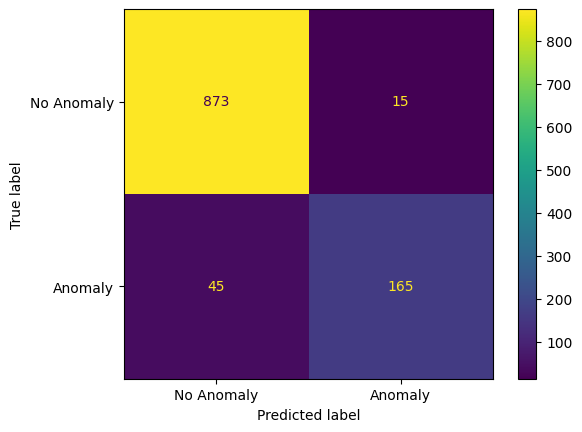

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set link type
link_type = 'Downlink' # 'Uplink', 'Downlink', 'Video'

# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
throughput_model.compile(optimizer='adam', 
            loss={'throughput': 'mse'},
            metrics={'throughput': 'accuracy'})

reliability_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/nn_v4_multimodulation_video_sinr_dl/model.001-0.2191.h5", compile=False)
reliability_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

# Load base case reliability df
base_case_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_Reliability.csv")
base_case_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
base_case_df["Reliability"] = base_case_df["Num_Reliable"] / base_case_df["Num_Sent"]

# Process input data
base_case_df["Mean_SINR_dB"] = base_case_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
base_case_df["Std_Dev_SINR_dB"] = base_case_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))
mean_sinr = base_case_df["Mean_SINR_dB"].values
std_dev_sinr = base_case_df["Std_Dev_SINR_dB"].values
# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = base_case_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = base_case_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values
# Get base case predicted throughput
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
throughput_prediction = throughput_model.predict(model_inputs)
reliability_prediction = reliability_model.predict(model_inputs)

# Convert output to throughput in bps
if link_type == "Uplink":
    max_throughput = 500000
    min_throughput = 0
elif link_type == "Downlink":
    max_throughput = 20000
    min_throughput = 0
elif link_type == "Video":
    max_throughput = 250000 
    min_throughput = 0

base_case_scenario = base_case_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]

anomaly_types = ["Type1", "Type2"]
num_uavs = [1,2,4]
anomaly_dists = ["Near", "Moderate", "Far"]

anomaly_df_list = []
for anomaly_type in anomaly_types:
    for num_uav in num_uavs:
        for anomaly_dist in anomaly_dists:
            # Load anomaly dataset
            anomaly_root_path = "/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Anomaly_{}_{}UAV_{}".format(anomaly_type, num_uav, anomaly_dist)
            anomaly_reliability_df = pd.read_csv(os.path.join(anomaly_root_path, "TestCase8_Anomaly_{}_{}UAV_{}_{}_Reliability.csv".format(anomaly_type, num_uav, anomaly_dist, link_type)))
            anomaly_throughput_df = pd.read_csv(os.path.join(anomaly_root_path, "TestCase8_Anomaly_{}_{}UAV_{}_{}_MeanThroughput.csv".format(anomaly_type, num_uav, anomaly_dist, link_type)))
            anomaly_reliability_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
            anomaly_throughput_df.sort_values(by=["Horizontal_Distance"], inplace=True) # Sort just in case. Each case should only be one scenario
            anomaly_reliability_df["Reliability"] = anomaly_reliability_df["Num_Reliable"] / anomaly_reliability_df["Num_Sent"]
            anomaly_reliability_df["Base_Case_Reliability"] = base_case_df["Reliability"]
            anomaly_reliability_df["Predicted_Reliability"] = [prob[0] for prob in reliability_prediction]

            # Make sure the horizontal distances, height, UAV send int and modulation between base case and anomaly are the same
            anomaly_reliability_scenario = anomaly_reliability_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]
            anomaly_throughput_scenario = anomaly_throughput_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation"]]
            assert base_case_scenario.equals(anomaly_reliability_scenario), "Inputs of Base Case and Anomaly Reliability DFs Does Not Match!"
            assert anomaly_throughput_scenario.equals(anomaly_reliability_scenario), "Inputs of Anomaly Reliability and Anomaly Throughput DFs Does Not Match!"

            # If using mean throughput from simulation to test, UNCOMMENT below ---------------------------------------------------
            anomaly_reliability_df['Mean_Throughput'] = anomaly_throughput_df['MeanThroughput'].values
            anomaly_reliability_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in throughput_prediction]
            anomaly_reliability_df["Abs_Err_Throughput"] = abs(anomaly_throughput_df['MeanThroughput'].values - anomaly_reliability_df['Predicted_Throughput'].values)
            # ----------------------------------------------------------------------------------------------------------------------

            # # If using throughput samples from simulation to test, UNCOMMENT below ------------------------------------------------
            # base_case_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
            # def find_throughput(h_dist, height, df):
            #     # Using h_dist and height, find the value of "Predicted_Throughput" in df
            #     return df.loc[(df["Horizontal_Distance"] == h_dist) & (df["Height"] == height)]["Predicted_Throughput"].values[0]
            # anomaly_throughput_df["Predicted_Throughput"] = anomaly_throughput_df.apply(lambda x: find_throughput(x['Horizontal_Distance'], x['Height'], base_case_df), axis=1)
            # anomaly_throughput_df["Abs_Err_Throughput"] = abs(anomaly_throughput_df['Throughput'].values - anomaly_throughput_df['Predicted_Throughput'].values)
            # # ----------------------------------------------------------------------------------------------------------------------

            # Ground truth for anomaly (compare difference between base and anomalous reliability based on a threshold)
            RELIABILITY_DIFF_TH = 0.02 # Threshold for considering anomalous reliability 
            anomaly_reliability_df["Abs_Diff_Reliability"] = abs(anomaly_reliability_df["Reliability"].values - base_case_df["Reliability"].values)
            anomaly_reliability_df["Anomaly"] = anomaly_reliability_df["Abs_Diff_Reliability"] > RELIABILITY_DIFF_TH

            # Detecting for anomaly using predicted throughput
            # Method 1, using mean and std dev of abs err in throughput prediction --------------------------------------------------
            THROUGHPUT_DIFF_TH = 995 # Threshold for predicting anomalous reliability 
            anomaly_reliability_df["Predicted_Anomaly"] = anomaly_reliability_df["Abs_Err_Throughput"] > THROUGHPUT_DIFF_TH

            # Record the anomaly test case details
            anomaly_reliability_df["Type"] = anomaly_type
            anomaly_reliability_df["Num_Interferer_UAV"] = num_uav
            anomaly_reliability_df["Interferer_Distance"] = anomaly_dist
            anomaly_df_list.append(anomaly_reliability_df)

anomaly_df = pd.concat(anomaly_df_list)
# Get corrected reliability
anomaly_df["Corrected_Reliability"] = anomaly_df["Mean_Throughput"] / anomaly_df["Predicted_Throughput"] * anomaly_df["Predicted_Reliability"]
anomaly_df.loc[anomaly_df["Predicted_Throughput"]==0, "Corrected_Reliability"] = 0
anomaly_df["Abs_Err_Corrected_Reliability"] = abs(anomaly_df["Reliability"].values - anomaly_df["Corrected_Reliability"].values)
print("Mean Abs Err Corrected Reliability: ", anomaly_df["Abs_Err_Corrected_Reliability"].mean())

# Save results to CSV
anomaly_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Downlink_AnomalyDetection.csv")

# Get anomaly detection accuracy and confusion matrix
cm = confusion_matrix(anomaly_df["Anomaly"], anomaly_df["Predicted_Anomaly"])
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Anomaly Accuracy Score: ", ACC[1])
print("Anomaly Sensitivity Score: ", TPR[1])
print("Anomaly Specificity Score: ", TNR[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(["No Anomaly", "Anomaly"]))
disp.plot()


## Test Base Case Throughput (for False Positives)

In [11]:
# Set link type
link_type = 'downlink' # 'uplink', 'downlink', 'video'

# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
throughput_model.compile(optimizer='adam', 
              loss={'throughput': 'mse'},
              metrics={'throughput': 'accuracy'})

# Load base case reliability df
base_case_throughput_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_MeanThroughput.csv")

# Process input data
base_case_throughput_df["Mean_SINR_dB"] = base_case_throughput_df["Mean_SINR"].apply(lambda x: 10*math.log10(x))
base_case_throughput_df["Std_Dev_SINR_dB"] = base_case_throughput_df["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))
mean_sinr = base_case_throughput_df["Mean_SINR_dB"].values
std_dev_sinr = base_case_throughput_df["Std_Dev_SINR_dB"].values
base_case_throughput_df.drop(["Mean_SINR_dB", "Std_Dev_SINR_dB"], axis=1)
# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = base_case_df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = base_case_df["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)

# Convert output to throughput in bps
if link_type == "uplink":
    max_throughput = 500000
    min_throughput = 0
elif link_type == "downlink":
    max_throughput = 20000
    min_throughput = 0
elif link_type == "video":
    max_throughput = 250000 
    min_throughput = 0

base_case_throughput_df['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
base_case_throughput_df["Abs_Err_Throughput"] = abs(base_case_throughput_df['MeanThroughput'].values - base_case_throughput_df['Predicted_Throughput'].values)

# Detecting for anomaly using predicted throughput
# Method 1, using mean and std dev of abs err in throughput prediction --------------------------------------------------
MAE_THROUGHPUT = 225 # Mean of abs err for predicted throughput
SAE_THROUGHPUT = 550 # Std Dev of abs err for predicted throughput
THROUGHPUT_DIFF_TH = MAE_THROUGHPUT + 2*SAE_THROUGHPUT # Threshold for predicting anomalous reliability 
base_case_throughput_df["Predicted_Anomaly"] = base_case_throughput_df["Abs_Err_Throughput"] > THROUGHPUT_DIFF_TH

base_case_throughput_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Anomaly/TestCase8_Base_Case/TestCase8_Base_Case_Downlink_PredictedThroughput.csv")


2/2 [==============================] - 0s 4ms/step


## Test on Holdout Dataset (To calculate threshold)

In [7]:
from sklearn.model_selection import train_test_split

def generate_troughput_train_holdout_dataset(dataset_details_csv, holdout_split=0.2):
    df_dtypes = {"Horizontal_Distance": np.float32, "Height": np.int16,	"U2G_Distance": np.int32, "UAV_Sending_Interval": np.int16, "Mean_SINR": np.float32, "Std_Dev_SINR": np.float32,
                 "Modulation": 'string', "Num_Sent": np.int32, "Num_Reliable": np.int32, "Num_Delay_Excd": np.int32, "Num_Incr_Rcvd": np.int32, "Num_Q_Overflow": np.int32}
    dataset_details = pd.read_csv(dataset_details_csv, 
                                  usecols = ["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "Modulation", "Throughput", "Num_Count"],
                                  dtype=df_dtypes)
    
    # For each scenario, get the throughput data and split it to train and holdout 
    scenarios = dataset_details[['Mean_SINR','Std_Dev_SINR','Modulation','UAV_Sending_Interval']].drop_duplicates()
    df_train_list = []
    df_holdout_list = []
    for scenario in scenarios.itertuples():
        scenario_df = dataset_details.loc[(dataset_details["Modulation"] == scenario.Modulation) & (dataset_details["UAV_Sending_Interval"] == scenario.UAV_Sending_Interval) & 
                          (dataset_details["Mean_SINR"] == scenario.Mean_SINR) & (dataset_details["Std_Dev_SINR"] == scenario.Std_Dev_SINR)]
        df_list = []
        for row in scenario_df.itertuples():
            throughput_data = {"Mean_SINR": row.Mean_SINR, "Std_Dev_SINR": row.Std_Dev_SINR, "UAV_Sending_Interval": row.UAV_Sending_Interval, "Modulation": row.Modulation, "Throughput": row.Throughput}
            # If Num_Count is one, just append the row to df_list
            if row.Num_Count == 1:
                df_list.append(throughput_data)
            else:
                df_list = df_list + [throughput_data.copy() for i in range(row.Num_Count)]
        df = pd.DataFrame(df_list)
        train, holdout = train_test_split(df, test_size=holdout_split, random_state=40, shuffle=True)
        df_train_list.append(train)
        df_holdout_list.append(holdout)
    df_train = pd.concat(df_train_list)
    df_holdout = pd.concat(df_holdout_list)
    return df_train, df_holdout

def process_mean_throughput(df):
    '''
    Calculate the mean throughput for each scenario
    Modified for this test script usage
    '''
    scenarios = df[['Mean_SINR','Std_Dev_SINR','Modulation','UAV_Sending_Interval']].drop_duplicates()
    output_df_list = []
    for row in scenarios.itertuples():
        scenario = df.loc[(df["Modulation"] == row.Modulation) & (df["UAV_Sending_Interval"] == row.UAV_Sending_Interval) & 
                          (df["Mean_SINR"] == row.Mean_SINR) & (df["Std_Dev_SINR"] == row.Std_Dev_SINR)]
        mean_throughput = scenario.Throughput.mean()
        output_df_list.append({"UAV_Sending_Interval": row.UAV_Sending_Interval, "Modulation": row.Modulation, "Mean_SINR": row.Mean_SINR, "Std_Dev_SINR": row.Std_Dev_SINR, "MeanThroughput": mean_throughput})
    return pd.DataFrame(output_df_list)

# Load dataset =================================================
print("Loading dataset")
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video"
df_bpsk_train, df_bpsk_holdout = generate_troughput_train_holdout_dataset(os.path.join(DATASET_PATH, "BPSK/BPSK_Downlink_Throughput.csv"), holdout_split=0.2)
df_qpsk_train, df_qpsk_holdout = generate_troughput_train_holdout_dataset(os.path.join(DATASET_PATH, "QPSK/QPSK_Downlink_Throughput.csv"), holdout_split=0.2)
df_qam16_train, df_qam16_holdout = generate_troughput_train_holdout_dataset(os.path.join(DATASET_PATH, "QAM16/QAM16_Downlink_Throughput.csv"), holdout_split=0.2)
df_qam64_train, df_qam64_holdout = generate_troughput_train_holdout_dataset(os.path.join(DATASET_PATH, "QAM64/QAM64_Downlink_Throughput.csv"), holdout_split=0.2)
df_holdout = pd.concat([df_bpsk_holdout, df_qpsk_holdout, df_qam16_holdout, df_qam64_holdout])
print("Processing mean throughput")
df_holdout = process_mean_throughput(df_holdout)

# Set link type
link_type = 'downlink' # 'uplink', 'downlink', 'video'

# Load throughput prediction model
throughput_model = tf.keras.models.load_model("/home/research-student/omnet-fanet/nn_checkpoints/throughput_predict_nn_v4_video_sinr_dl/model.020-0.0020.h5", compile=False)
throughput_model.compile(optimizer='adam', 
              loss={'throughput': 'mse'},
              metrics={'throughput': 'accuracy'})

# Process input data
df_holdout["Mean_SINR_dB"] = df_holdout["Mean_SINR"].apply(lambda x: 10*math.log10(x))
df_holdout["Std_Dev_SINR_dB"] = df_holdout["Std_Dev_SINR"].apply(lambda x: 10*math.log10(x))
mean_sinr = df_holdout["Mean_SINR_dB"].values
std_dev_sinr = df_holdout["Std_Dev_SINR_dB"].values
df_holdout.drop(["Mean_SINR_dB", "Std_Dev_SINR_dB"], axis=1, inplace=True)
# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = df_holdout["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1}).values
norm_modulation = df_holdout["Modulation"].replace({"BPSK":1, "QPSK":0.3333, "QAM16":-0.3333, "QAM64":-1}).values

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)

# Convert output to throughput in bps
if link_type == "uplink":
    max_throughput = 500000
    min_throughput = 0
elif link_type == "downlink":
    max_throughput = 20000
    min_throughput = 0
elif link_type == "video":
    max_throughput = 250000 
    min_throughput = 0

df_holdout['Predicted_Throughput'] = [prob[0]*(max_throughput-min_throughput)+min_throughput for prob in prediction]
df_holdout["Abs_Err_Throughput"] = abs(df_holdout['MeanThroughput'].values - df_holdout['Predicted_Throughput'].values)
df_holdout.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_MultiModulation_Hovering_Video/Holdout_Dataset_Downlink_PredictedThroughput.csv")

Loading dataset


Processing mean throughput


2023-08-02 16:18:20.441893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-02 16:18:20.441967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-02 16:18:20.442013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-02 16:18:20.442056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-08-02 16:18:20.442101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

344/344 [==============================] - 1s 3ms/step


In [10]:
mean_sinr = [700, 918]
std_dev_sinr = [300, 402]
# Normalize inputs
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_mean_sinr = [2*(m-min_mean_sinr) / (max_mean_sinr-min_mean_sinr) - 1 for m in mean_sinr]
norm_std_dev_sinr = [2*(s-min_std_dev_sinr) / (max_std_dev_sinr-min_std_dev_sinr) - 1 for s in std_dev_sinr]
norm_uav_send_int = [-1, -1]
norm_modulation = [1,1]

# Run inference
model_inputs = list(zip(norm_mean_sinr, norm_std_dev_sinr, norm_uav_send_int, norm_modulation))
prediction = throughput_model.predict(model_inputs)
print(prediction)

1/1 [==============================] - 0s 40ms/step
[[0.]
 [0.]]
